# EDA — Consolidated PII Dataset

Loads `consolidated.jsonl` and `entity_types.json` from the consolidation step and analyses the data before fine-tuning.

## Imports & paths

In [2]:
import json
import warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from tabulate import tabulate

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')

# ----- adjust these paths if your layout differs -----
DATA_DIR = Path('../notebooks/pii_datasets/consolidated')  # relative to this notebook
CONSOLIDATED_FILE = DATA_DIR / 'consolidated.jsonl'
ENTITY_TYPES_FILE = DATA_DIR / 'entity_types.json'
# ------------------------------------------------------

assert CONSOLIDATED_FILE.exists(), f'File not found: {CONSOLIDATED_FILE}'
assert ENTITY_TYPES_FILE.exists(), f'File not found: {ENTITY_TYPES_FILE}'

print(f'consolidated.jsonl : {CONSOLIDATED_FILE.stat().st_size / 1e6:.1f} MB')
print(f'entity_types.json  : {ENTITY_TYPES_FILE.stat().st_size / 1e3:.1f} KB')

consolidated.jsonl : 2067.2 MB
entity_types.json  : 2.5 KB


## Load entity type report

In [3]:
with open(ENTITY_TYPES_FILE) as f:
    entity_report = json.load(f)

global_types = entity_report['global']
per_source   = entity_report['per_source']

print(f'Total canonical entity types : {len(global_types)}')
print(f'Sources                       : {len(per_source)}')
print(f'\nAll entity types:')
for t in global_types:
    print(f'  {t}')

Total canonical entity types : 48
Sources                       : 8

All entity types:
  ACCOUNT_NUMBER
  ACCOUNT_PIN
  ADDRESS
  AMOUNT
  API_KEY
  BANK_ROUTING_NUMBER
  BBAN
  BIC
  COMPANY
  CREDIT_CARD
  CREDIT_CARD_NUMBER
  CREDIT_CARD_SECURITY_CODE
  CRYPTO_ADDRESS
  CURRENCY
  CUSTOMER_ID
  DATE
  DATE_OF_BIRTH
  DATE_TIME
  DRIVER_LICENSE_NUMBER
  EMAIL
  EMPLOYEE_ID
  FINANCIAL_ENTITY
  FIRST_NAME
  IBAN
  IPV4
  IPV6
  IP_ADDRESS
  JOB
  LAST_NAME
  LOC
  LOCAL_LATLNG
  MISC
  NAME
  ORG
  PASSPORT_NUMBER
  PASSWORD
  PERSON
  PHONE
  PHONE_NUMBER
  PIN
  SSN
  STREET_ADDRESS
  SWIFT_BIC_CODE
  TIME
  URL
  USERNAME
  USER_NAME
  VEHICLE


In [4]:
# Entity type coverage per source
coverage_rows = []
for source, types in sorted(per_source.items()):
    coverage_rows.append({'source': source, 'num_types': len(types), 'types': ', '.join(sorted(types))})

coverage_df = pd.DataFrame(coverage_rows).sort_values('num_types', ascending=False)
print(tabulate(coverage_df[['source', 'num_types']], headers='keys', tablefmt='simple', showindex=False))

source               num_types
-----------------  -----------
gretel_finance              29
isotonic_pii_200k           23
ai4privacy_300k              9
ai4privacy_400k              7
multinerd                    6
conll2003                    4
wikiann                      3
finer_139                    1


## Load consolidated data

In [5]:
records = []
with open(CONSOLIDATED_FILE) as f:
    for line in f:
        line = line.strip()
        if line:
            records.append(json.loads(line))

print(f'Total records loaded: {len(records):,}')

Total records loaded: 2,369,883


In [6]:
# Build a flat dataframe with per-record stats
rows = []
for rec in records:
    tokens = rec['tokens']
    labels = rec['labels']
    source = rec['source']

    n_tokens = len(tokens)
    entity_counts = Counter(
        lbl[2:] for lbl in labels if lbl.startswith('B-')
    )
    has_pii = any(lbl != 'O' for lbl in labels)
    n_entities = sum(entity_counts.values())

    rows.append({
        'source': source,
        'n_tokens': n_tokens,
        'n_entities': n_entities,
        'has_pii': has_pii,
        'entity_types_present': list(entity_counts.keys()),
        'entity_counts': dict(entity_counts),
    })

df = pd.DataFrame(rows)
print(df.dtypes)
df.head(3)

source                     str
n_tokens                 int64
n_entities               int64
has_pii                   bool
entity_types_present    object
entity_counts           object
dtype: object


,source,n_tokens,n_entities,has_pii,entity_types_present,entity_counts
0,ai4privacy_400k,122,8,True,"[USERNAME, FINANCIAL_ENTITY, ADDRESS, LOC, CRE...","{'USERNAME': 2, 'FINANCIAL_ENTITY': 2, 'ADDRES..."
1,ai4privacy_400k,94,7,True,"[USERNAME, FINANCIAL_ENTITY, LOC, EMAIL]","{'USERNAME': 4, 'FINANCIAL_ENTITY': 1, 'LOC': ..."
2,ai4privacy_400k,84,7,True,"[USERNAME, FINANCIAL_ENTITY, LOC, EMAIL]","{'USERNAME': 3, 'FINANCIAL_ENTITY': 2, 'LOC': ..."


## High-level overview

In [7]:
total = len(df)
with_pii = df['has_pii'].sum()
without_pii = total - with_pii

print(f'Total records          : {total:>10,}')
print(f'Records with PII       : {with_pii:>10,}  ({with_pii/total*100:.1f}%)')
print(f'Records without PII    : {without_pii:>10,}  ({without_pii/total*100:.1f}%)')
print(f'Total tokens           : {df["n_tokens"].sum():>10,}')
print(f'Avg tokens per record  : {df["n_tokens"].mean():>10.1f}')
print(f'Avg entities per record: {df["n_entities"].mean():>10.2f}')

Total records          :  2,369,883
Records with PII       :  1,206,409  (50.9%)
Records without PII    :  1,163,474  (49.1%)
Total tokens           : 133,695,549
Avg tokens per record  :       56.4
Avg entities per record:       1.21


## Records per source

In [8]:
source_counts = df['source'].value_counts().reset_index()
source_counts.columns = ['source', 'records']
source_counts['pct'] = (source_counts['records'] / total * 100).round(2)
print(tabulate(source_counts, headers='keys', tablefmt='simple', showindex=False))

source               records    pct
-----------------  ---------  -----
finer_139            1121256  47.31
ai4privacy_400k       325511  13.74
isotonic_pii_200k     209261   8.83
few_nerd              188239   7.94
ai4privacy_300k       177652   7.5
multinerd             131280   5.54
nvidia_nemotron       100000   4.22
gretel_finance         55940   2.36
wikiann                40000   1.69
conll2003              20744   0.88


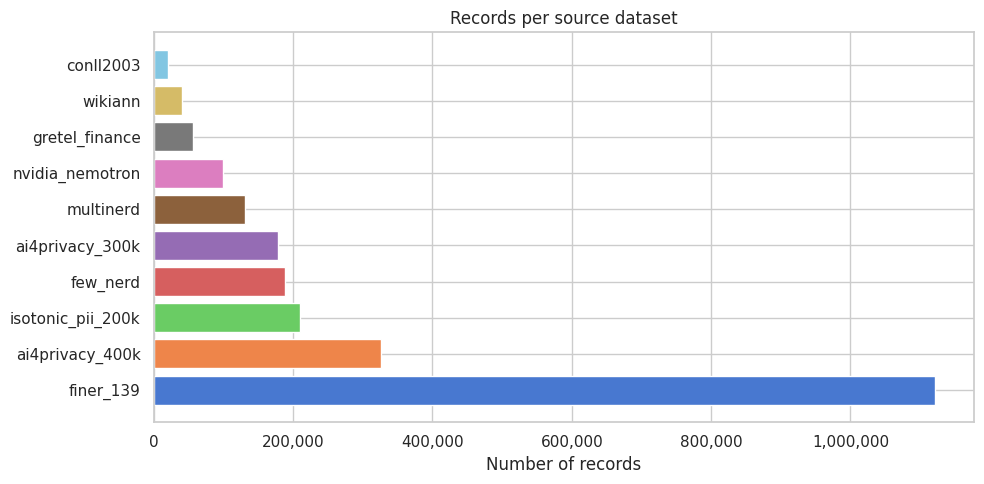

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(source_counts['source'], source_counts['records'], color=sns.color_palette('muted', len(source_counts)))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_xlabel('Number of records')
ax.set_title('Records per source dataset')
plt.tight_layout()
plt.show()

## PII presence rate per source

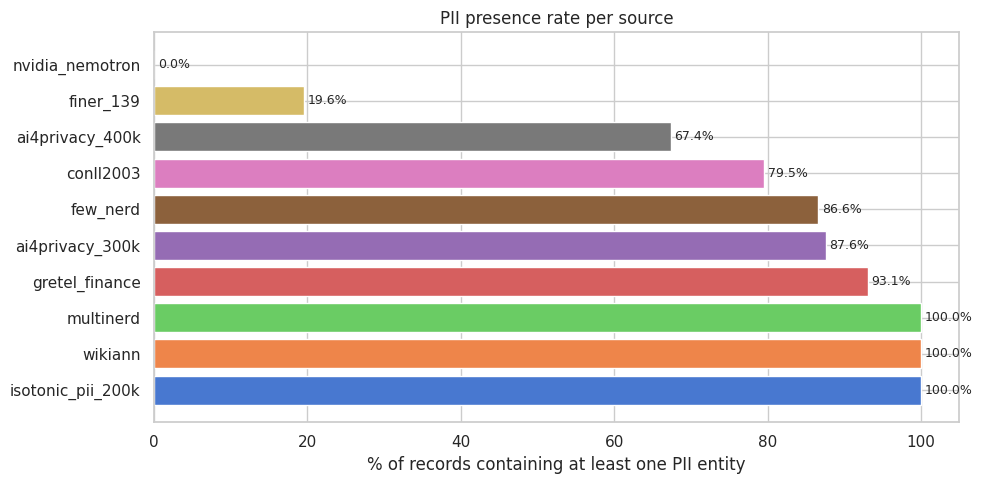

In [10]:
pii_rate = df.groupby('source')['has_pii'].mean().reset_index()
pii_rate.columns = ['source', 'pii_rate']
pii_rate = pii_rate.sort_values('pii_rate', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(pii_rate['source'], pii_rate['pii_rate'] * 100,
               color=sns.color_palette('muted', len(pii_rate)))
ax.set_xlabel('% of records containing at least one PII entity')
ax.set_title('PII presence rate per source')
ax.set_xlim(0, 105)
for bar, val in zip(bars, pii_rate['pii_rate']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f'{val*100:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

## Global entity type frequency

In [11]:
global_entity_counter = Counter()
for rec in records:
    for lbl in rec['labels']:
        if lbl.startswith('B-'):
            global_entity_counter[lbl[2:]] += 1

entity_freq_df = pd.DataFrame(
    global_entity_counter.most_common(),
    columns=['entity_type', 'count']
)
entity_freq_df['pct'] = (entity_freq_df['count'] / entity_freq_df['count'].sum() * 100).round(2)

print(f'Total entity mentions: {entity_freq_df["count"].sum():,}')
print(tabulate(entity_freq_df, headers='keys', tablefmt='simple', showindex=False))

Total entity mentions: 2,868,442
entity_type                  count    pct
-------------------------  -------  -----
FINANCIAL_ENTITY           1013029  35.32
PERSON                      297105  10.36
LOC                         274283   9.56
DATE                        148158   5.17
USERNAME                    117756   4.11
EMAIL                       113858   3.97
TIME                        107513   3.75
NAME                         97346   3.39
ADDRESS                      90433   3.15
IP_ADDRESS                   87817   3.06
ORG                          80507   2.81
COMPANY                      61537   2.15
MISC                         54594   1.9
STREET_ADDRESS               41966   1.46
JOB                          38926   1.36
CREDIT_CARD                  33589   1.17
CURRENCY                     27103   0.94
PASSWORD                     24127   0.84
CRYPTO_ADDRESS               22709   0.79
ACCOUNT_NUMBER               22423   0.78
PHONE                        21403   0.75
UR

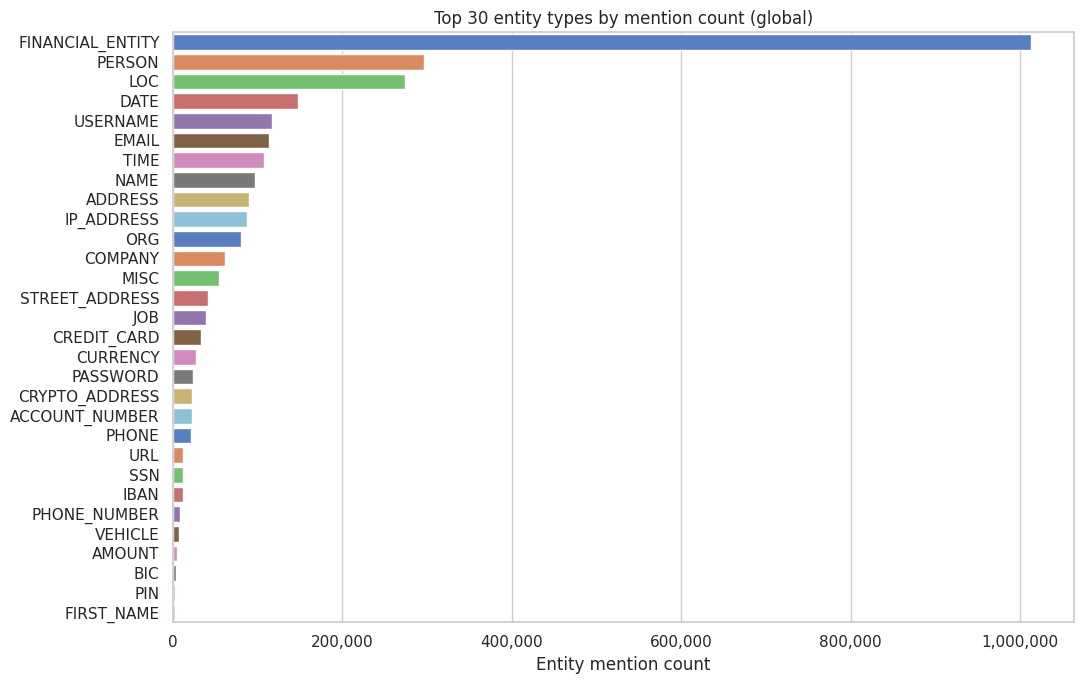

In [12]:
top_n = min(30, len(entity_freq_df))
plot_df = entity_freq_df.head(top_n)

fig, ax = plt.subplots(figsize=(11, 7))
sns.barplot(data=plot_df, y='entity_type', x='count', palette='muted', ax=ax)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title(f'Top {top_n} entity types by mention count (global)')
ax.set_xlabel('Entity mention count')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Entity type distribution per source (heatmap)

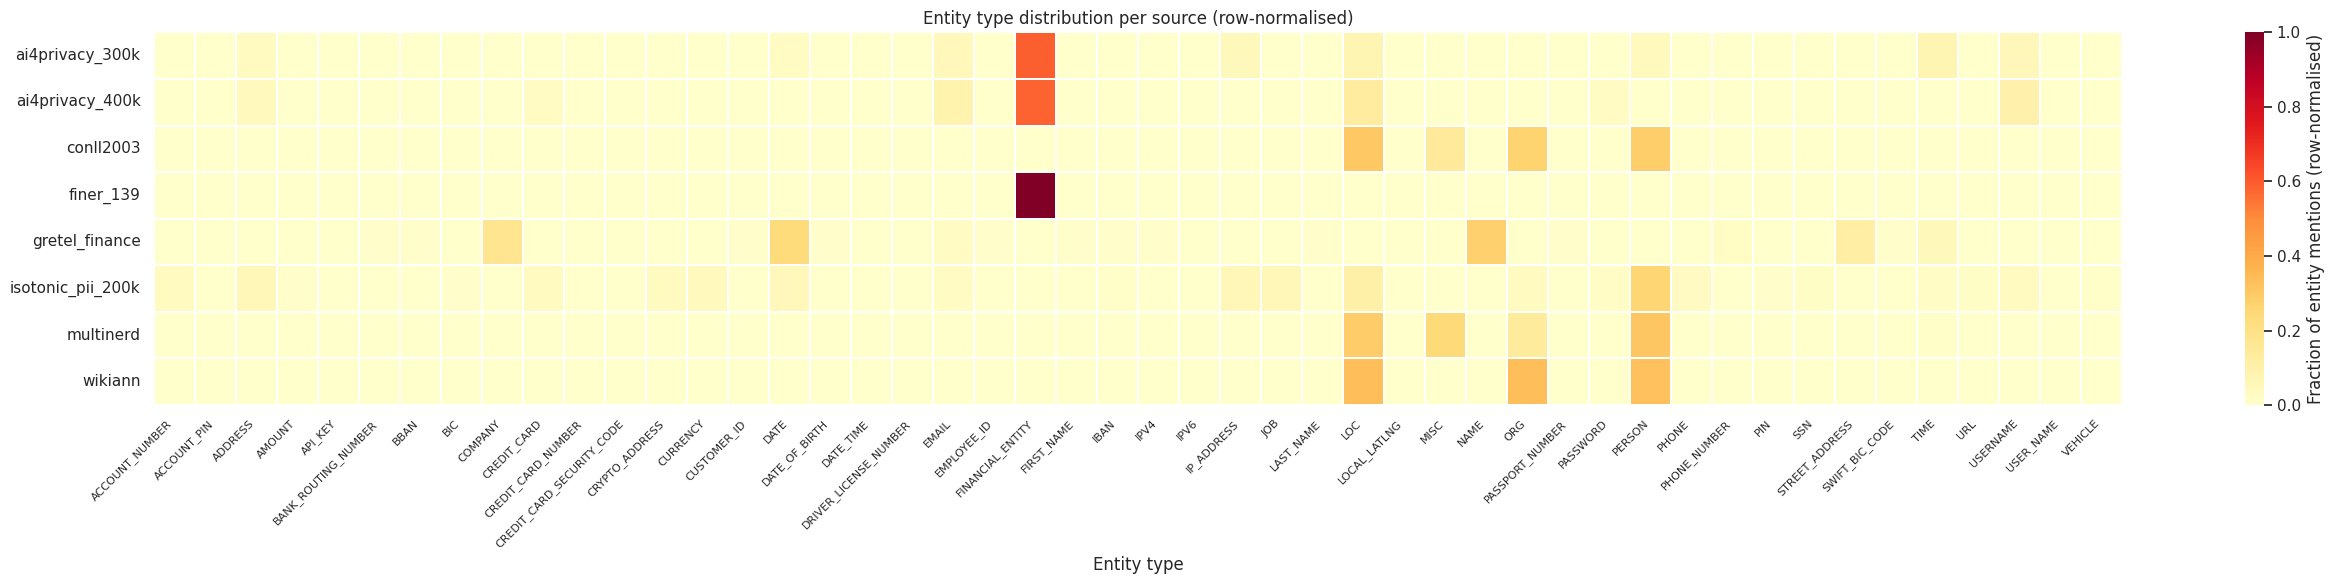

In [13]:
# Build source x entity_type count matrix
source_entity_counts = defaultdict(Counter)
for rec in records:
    src = rec['source']
    for lbl in rec['labels']:
        if lbl.startswith('B-'):
            source_entity_counts[src][lbl[2:]] += 1

all_entity_types = sorted(global_entity_counter.keys())
all_sources = sorted(source_entity_counts.keys())

heatmap_data = pd.DataFrame(
    index=all_sources,
    columns=all_entity_types,
    data=0,
    dtype=float
)
for src, counter in source_entity_counts.items():
    for etype, cnt in counter.items():
        if etype in heatmap_data.columns:
            heatmap_data.loc[src, etype] = cnt

# Row-normalise to show share within each source
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).fillna(0)

fig, ax = plt.subplots(figsize=(max(14, len(all_entity_types) * 0.55), max(6, len(all_sources) * 0.7)))
sns.heatmap(
    heatmap_norm,
    annot=False,
    fmt='.2f',
    cmap='YlOrRd',
    linewidths=0.3,
    ax=ax,
    cbar_kws={'label': 'Fraction of entity mentions (row-normalised)'}
)
ax.set_title('Entity type distribution per source (row-normalised)')
ax.set_xlabel('Entity type')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

## Sequence length analysis

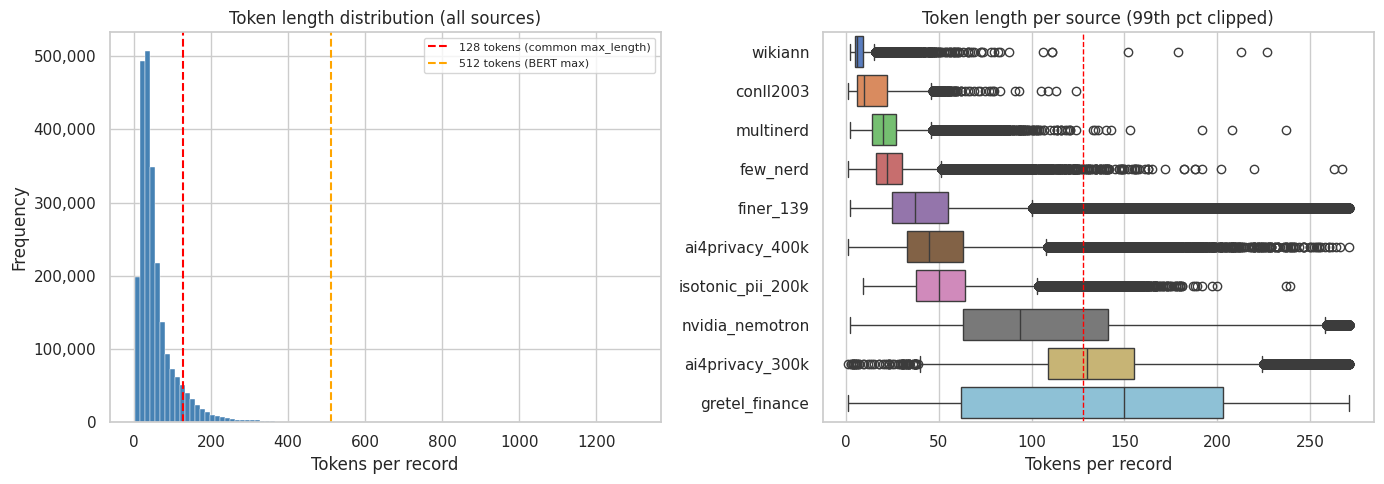

Records exceeding   64 tokens: 26.62%
Records exceeding  128 tokens: 8.41%
Records exceeding  256 tokens: 1.17%
Records exceeding  512 tokens: 0.04%


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(df['n_tokens'], bins=100, color='steelblue', edgecolor='white', linewidth=0.3)
axes[0].axvline(128, color='red', linestyle='--', label='128 tokens (common max_length)')
axes[0].axvline(512, color='orange', linestyle='--', label='512 tokens (BERT max)')
axes[0].set_xlabel('Tokens per record')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Token length distribution (all sources)')
axes[0].legend(fontsize=8)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Boxplot per source
src_order = df.groupby('source')['n_tokens'].median().sort_values().index.tolist()
df_plot = df[df['n_tokens'] <= df['n_tokens'].quantile(0.99)]  # clip extreme outliers for readability
sns.boxplot(data=df_plot, y='source', x='n_tokens', order=src_order, palette='muted', ax=axes[1])
axes[1].axvline(128, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Tokens per record')
axes[1].set_ylabel('')
axes[1].set_title('Token length per source (99th pct clipped)')

plt.tight_layout()
plt.show()

# Truncation risk
for cutoff in [64, 128, 256, 512]:
    pct = (df['n_tokens'] > cutoff).mean() * 100
    print(f'Records exceeding {cutoff:>4} tokens: {pct:.2f}%')

In [15]:
print('Sequence length percentiles:')
for pct in [50, 75, 90, 95, 99, 100]:
    print(f'  p{pct:>3}: {np.percentile(df["n_tokens"], pct):.0f} tokens')

Sequence length percentiles:
  p 50: 40 tokens
  p 75: 67 tokens
  p 90: 119 tokens
  p 95: 157 tokens
  p 99: 271 tokens
  p100: 1303 tokens


## 10. Entities per record distribution

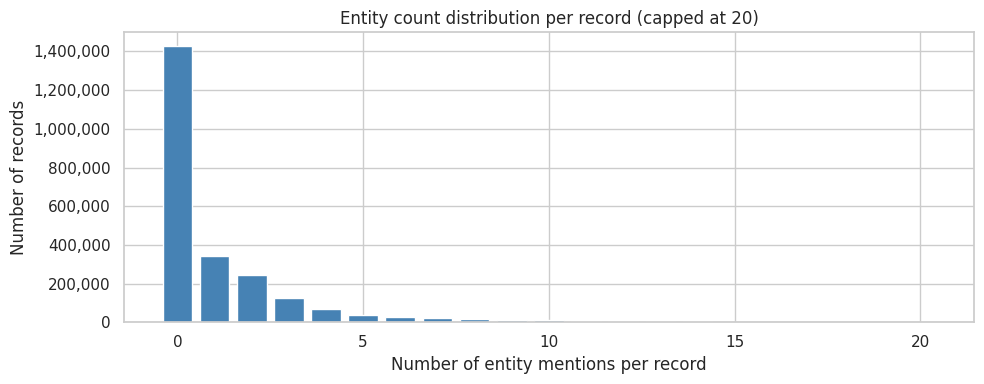

Records with 0 entities : 1,427,522 (60.2%)
Records with 1 entity   : 344,841
Records with 2+ entities: 597,520
Max entities in a record: 148


In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
n_ent_counts = df['n_entities'].value_counts().sort_index()
n_ent_plot = n_ent_counts[n_ent_counts.index <= 20]  # cap at 20 for readability
ax.bar(n_ent_plot.index, n_ent_plot.values, color='steelblue')
ax.set_xlabel('Number of entity mentions per record')
ax.set_ylabel('Number of records')
ax.set_title('Entity count distribution per record (capped at 20)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

print(f'Records with 0 entities : {(df["n_entities"]==0).sum():,} ({(df["n_entities"]==0).mean()*100:.1f}%)')
print(f'Records with 1 entity   : {(df["n_entities"]==1).sum():,}')
print(f'Records with 2+ entities: {(df["n_entities"]>=2).sum():,}')
print(f'Max entities in a record: {df["n_entities"].max()}')

## Label imbalance — O vs entity tokens

In [17]:
total_tokens = 0
entity_token_counter = Counter()
o_count = 0

for rec in records:
    for lbl in rec['labels']:
        total_tokens += 1
        if lbl == 'O':
            o_count += 1
        else:
            entity_token_counter[lbl[2:]] += 1  # strip B-/I-

entity_total = total_tokens - o_count
print(f'Total tokens  : {total_tokens:,}')
print(f'O tokens      : {o_count:,}  ({o_count/total_tokens*100:.2f}%)')
print(f'Entity tokens : {entity_total:,}  ({entity_total/total_tokens*100:.2f}%)')
print(f'\nImbalance ratio (O : entity) = {o_count/entity_total:.1f} : 1')

Total tokens  : 133,695,549
O tokens      : 119,104,971  (89.09%)
Entity tokens : 14,590,578  (10.91%)

Imbalance ratio (O : entity) = 8.2 : 1


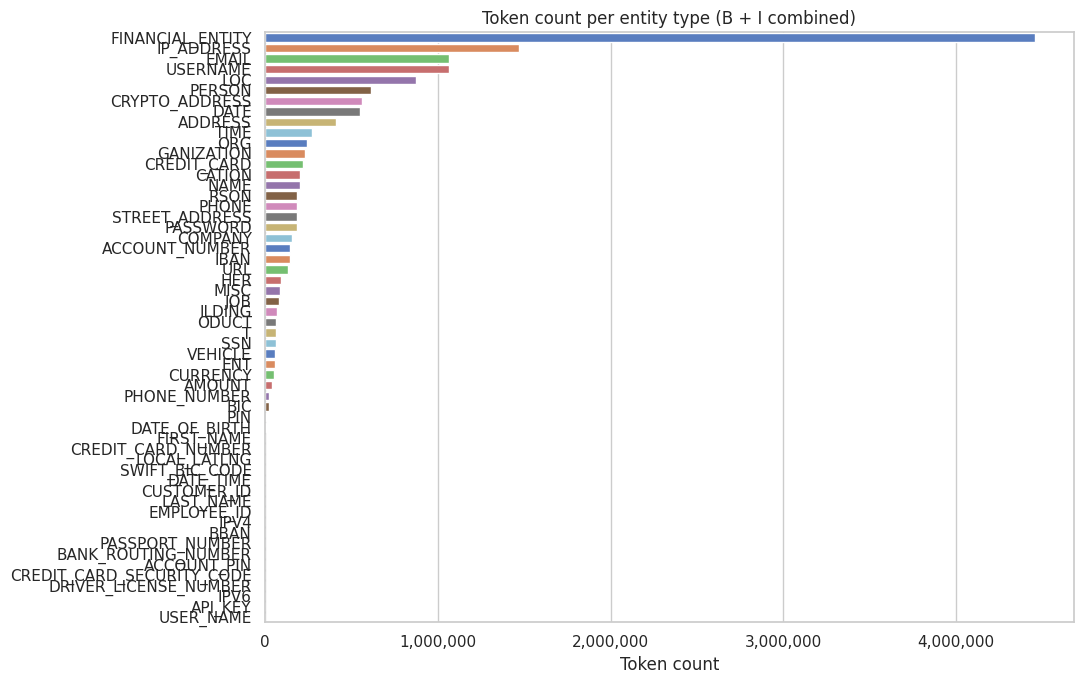

In [18]:
# Token-level distribution per entity type
token_df = pd.DataFrame(
    entity_token_counter.most_common(),
    columns=['entity_type', 'token_count']
)
token_df['pct_of_entity_tokens'] = (token_df['token_count'] / entity_total * 100).round(2)

fig, ax = plt.subplots(figsize=(11, 7))
sns.barplot(data=token_df, y='entity_type', x='token_count', palette='muted', ax=ax)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Token count per entity type (B + I combined)')
ax.set_xlabel('Token count')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Co-occurrence of entity types within the same record

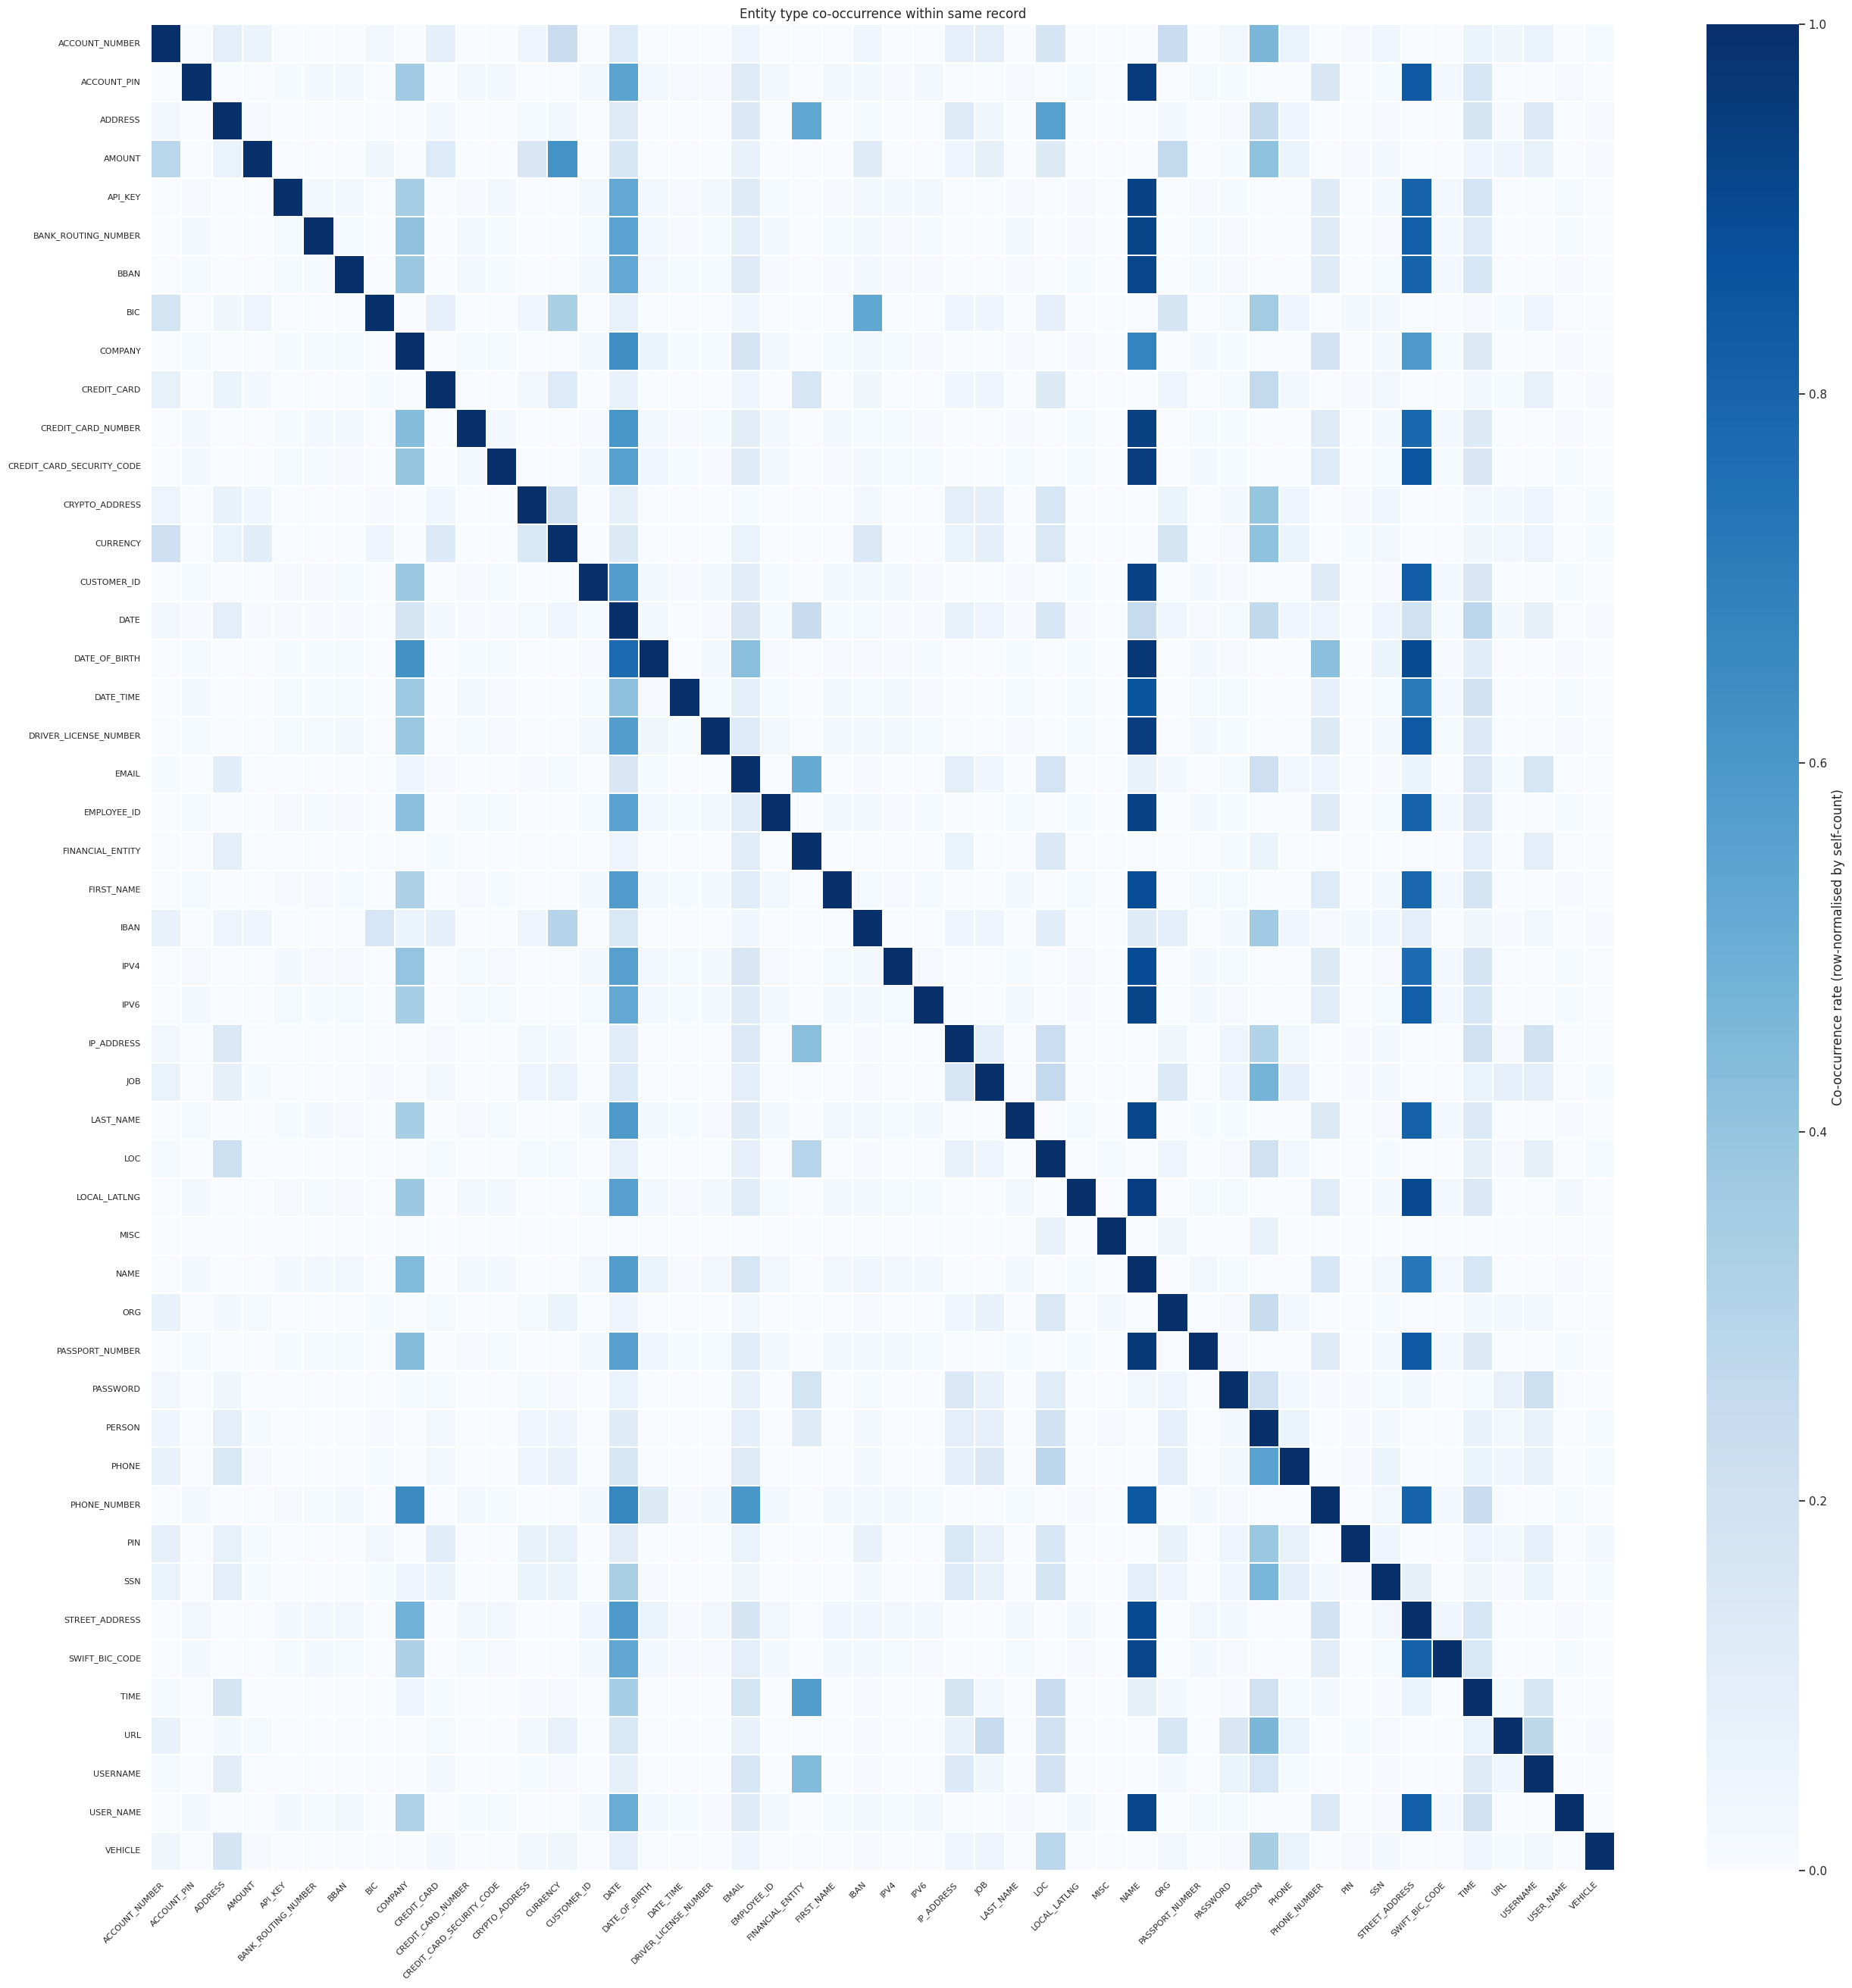

In [19]:
# Build co-occurrence matrix
type_list = sorted(global_entity_counter.keys())
cooc = pd.DataFrame(0, index=type_list, columns=type_list, dtype=int)

for rec in records:
    types_in_rec = set(
        lbl[2:] for lbl in rec['labels'] if lbl.startswith('B-')
    )
    for a in types_in_rec:
        for b in types_in_rec:
            if a in cooc.index and b in cooc.columns:
                cooc.loc[a, b] += 1

# Normalise by diagonal (self-count) for readable colour scale
diag = np.diag(cooc.values).copy()
diag[diag == 0] = 1
cooc_norm = cooc.div(diag, axis=0)

fig, ax = plt.subplots(figsize=(max(12, len(type_list) * 0.55), max(10, len(type_list) * 0.55)))
sns.heatmap(
    cooc_norm,
    cmap='Blues',
    linewidths=0.2,
    ax=ax,
    cbar_kws={'label': 'Co-occurrence rate (row-normalised by self-count)'}
)
ax.set_title('Entity type co-occurrence within same record')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## Rare entity types — risk assessment

In [20]:
MIN_MENTION_THRESHOLD = 500

rare = entity_freq_df[entity_freq_df['count'] < MIN_MENTION_THRESHOLD]
common = entity_freq_df[entity_freq_df['count'] >= MIN_MENTION_THRESHOLD]

print(f'Entity types with >= {MIN_MENTION_THRESHOLD} mentions (safe to train): {len(common)}')
print(f'Entity types with <  {MIN_MENTION_THRESHOLD} mentions (risk of poor recall): {len(rare)}')

if not rare.empty:
    print(f'\nRare entity types:')
    print(tabulate(rare, headers='keys', tablefmt='simple', showindex=False))

Entity types with >= 500 mentions (safe to train): 48
Entity types with <  500 mentions (risk of poor recall): 0


## Per-source entity type coverage matrix

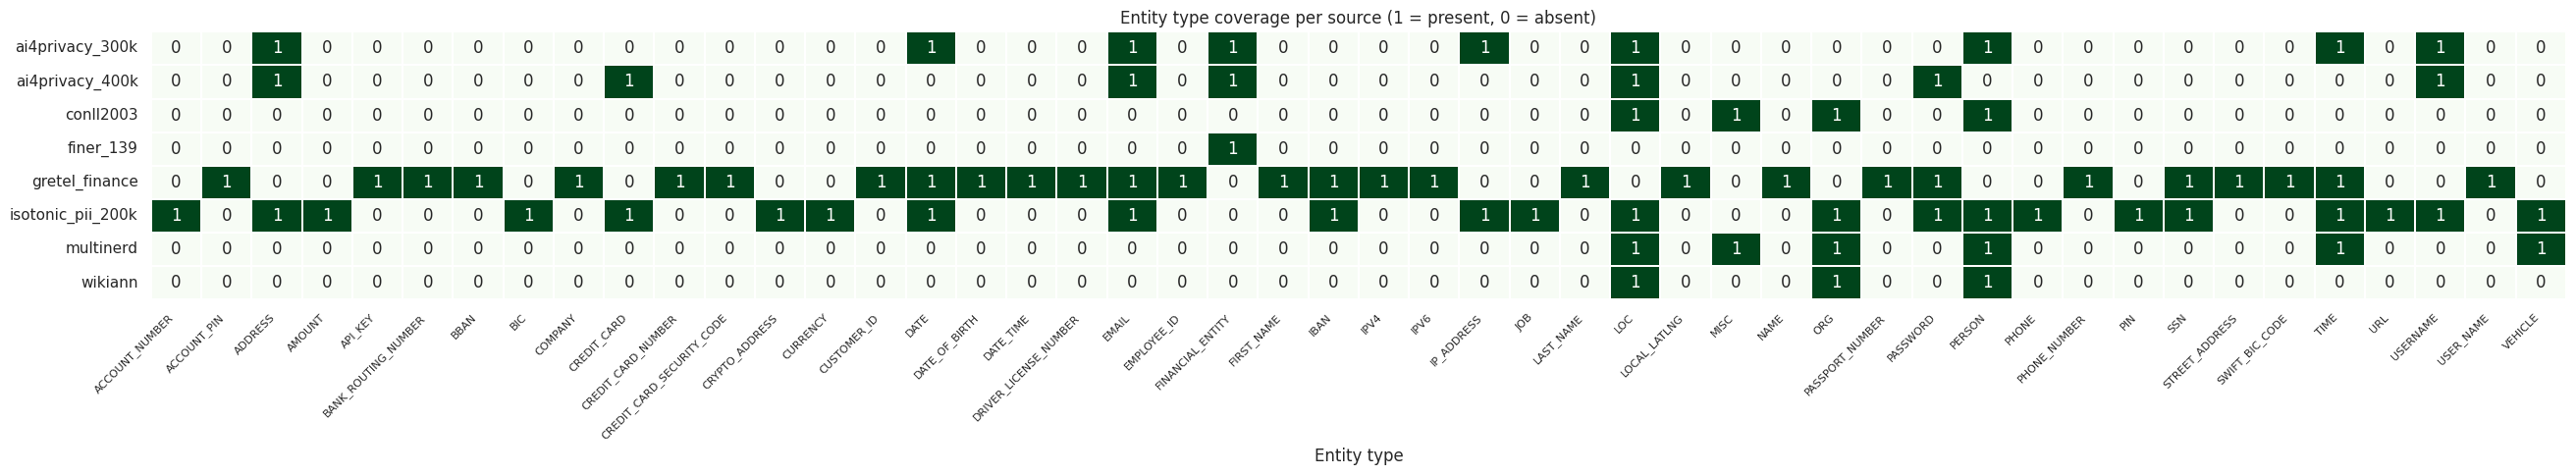

Entity types covered by exactly one source (32): ['ACCOUNT_NUMBER', 'ACCOUNT_PIN', 'AMOUNT', 'API_KEY', 'BANK_ROUTING_NUMBER', 'BBAN', 'BIC', 'COMPANY', 'CREDIT_CARD_NUMBER', 'CREDIT_CARD_SECURITY_CODE', 'CRYPTO_ADDRESS', 'CURRENCY', 'CUSTOMER_ID', 'DATE_OF_BIRTH', 'DATE_TIME', 'DRIVER_LICENSE_NUMBER', 'EMPLOYEE_ID', 'FIRST_NAME', 'IPV4', 'IPV6', 'JOB', 'LAST_NAME', 'LOCAL_LATLNG', 'NAME', 'PASSPORT_NUMBER', 'PHONE', 'PHONE_NUMBER', 'PIN', 'STREET_ADDRESS', 'SWIFT_BIC_CODE', 'URL', 'USER_NAME']


In [22]:
# Binary presence/absence matrix: which sources cover which entity types
presence = pd.DataFrame(
    False,
    index=all_sources,
    columns=all_entity_types,
    dtype=bool
)
for src, counter in source_entity_counts.items():
    for etype in counter:
        if etype in presence.columns:
            presence.loc[src, etype] = True

fig, ax = plt.subplots(figsize=(max(14, len(all_entity_types) * 0.55), max(5, len(all_sources) * 0.6)))
sns.heatmap(
    presence.astype(int),
    cmap='Greens',
    linewidths=0.3,
    cbar=False,
    ax=ax,
    annot=True,
    fmt='d'
)
ax.set_title('Entity type coverage per source (1 = present, 0 = absent)')
ax.set_xlabel('Entity type')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# Types only covered by a single source
single_source_types = [col for col in presence.columns if presence[col].sum() == 1]
print(f'Entity types covered by exactly one source ({len(single_source_types)}): {single_source_types}')

## Summary table — per-source statistics

In [23]:
summary_stats = []
for src in all_sources:
    src_df = df[df['source'] == src]
    total_entity_mentions = sum(source_entity_counts[src].values())
    summary_stats.append({
        'source': src,
        'records': len(src_df),
        'pii_rate_%': round(src_df['has_pii'].mean() * 100, 1),
        'avg_tokens': round(src_df['n_tokens'].mean(), 1),
        'median_tokens': int(src_df['n_tokens'].median()),
        'total_entity_mentions': total_entity_mentions,
        'entity_types': len(source_entity_counts[src]),
    })

summary_stats_df = pd.DataFrame(summary_stats).sort_values('records', ascending=False)
print(tabulate(summary_stats_df, headers='keys', tablefmt='simple', showindex=False))

source               records    pii_rate_%    avg_tokens    median_tokens    total_entity_mentions    entity_types
-----------------  ---------  ------------  ------------  ---------------  -----------------------  --------------
finer_139            1121256          19.6          45.6               37                   188035               1
ai4privacy_400k       325511          67.4          50.5               45                   355376               7
isotonic_pii_200k     209261         100            53.3               50                   637126              23
ai4privacy_300k       177652          87.6         135                130                  1041959               9
multinerd             131280         100            21.6               20                   201769               6
gretel_finance         55940          93.1         168.7              174                   353053              29
wikiann                40000         100             8                  6       